In [1]:
import matplotlib.pyplot as plt 
from matplotlib import dates, colors, ticker
import numpy as np 
import pandas as pd 
from astropy import units as u 
from astropy.io import fits
from pathlib import Path
from astropy.table import QTable, vstack
from astropy.time import Time
from sunpy.time import parse_time
from sunpy.net import Fido, attrs as a
from sunpy import timeseries as ts
import pandas as pd
import seaborn as sns
sns.set_context("paper", font_scale=1.5, rc={"font.family" : "Helvetica"})


In [2]:
tstart = Time("2021-11-01 01:22")
tend = Time("2021-11-01 01:50")

In [3]:
res = Fido.search(a.Time(tstart, tend), a.Instrument("XRS"), a.goes.SatelliteNumber(16))
Fido.fetch(res, path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['sci_xrsf-l2-flx1s_g16_d20211101_v2-1-0.nc']

In [4]:
goes_ts = ts.TimeSeries('sci_xrsf-l2-flx1s_g16_d20211101_v2-1-0.nc').truncate(tstart.datetime, tend.datetime)
gl = goes_ts.to_dataframe()["xrsb"].resample("60s").mean()
gs = goes_ts.to_dataframe()["xrsa"].resample("60s").mean()

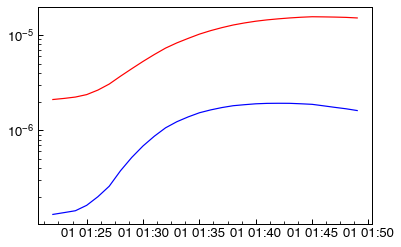

In [5]:
fig, ax = plt.subplots()
ax.plot(gl, color='r')
ax.plot(gs, color='b')
plt.yscale("log")

## Lets read the STIX data

### STIX files

In [6]:
stix_filespec = "solo_L1A_stix-sci-spectrogram-2111010001_20211101T003900-20211101T032545_055094_V01.fits"
fits_path_bk = "solo_L1A_stix-sci-xray-l1-2111010038_20211101T140006-20211101T153606_056537_V01.fits"
stix_filel1 = "solo_L1A_stix-sci-xray-l1-2111010024_20211101T010049-20211101T023158_017507_V01.fits"

fits_bg1 = "solo_L1A_stix-sci-xray-l1-2110310071_20211031T111705-20211031T125305_056536_V01.fits"
fits_bg2 = "solo_L1A_stix-sci-xray-l1-2111010016_20211101T100013-20211101T114013_017219_V01.fits"

In [7]:
ls *.fits

ospex_results_1powerlaw_fermi_18-60.fits
ospex_results_20_jul_2022.fits
ospex_results_26_jul_2022_1pow+l1_1550.fits
ospex_results_26_jul_2022_spec_1845_1pow.fits
ospex_results_26_jul_2022_stix_spec_6_45_vththick2.fits
ospex_results_STIXL1_6-60keV_vth_thick2.fits
solo_L1A_stix-sci-spectrogram-2111010001_20211101T003900-20211101T032545_055094_V01.fits
solo_L1A_stix-sci-xray-l1-2110310071_20211031T111705-20211031T125305_056536_V01.fits
solo_L1A_stix-sci-xray-l1-2111010016_20211101T100013-20211101T114013_017219_V01.fits
solo_L1A_stix-sci-xray-l1-2111010024_20211101T010049-20211101T023158_017507_V01.fits
solo_L1A_stix-sci-xray-l1-2111010038_20211101T140006-20211101T153606_056537_V01.fits
stx_spectrum_20211101_0040.fits
stx_spectrum_20211101_0102.fits
stx_srm_20211101_0040.fits
stx_srm_20211101_0102.fits


In [8]:
def read_stix_fitsl1(filename, tstart=None, tend=None, light_time_correction=0*u.s):
    file = Path(filename)
    header = fits.getheader(file)
    control = QTable.read(file, hdu=1)
    data = QTable.read(file, hdu=2)
    data['time'] = Time(header['date_obs']) + data['time']
    energies = QTable.read(file, hdu=3)
    data["time"] = data["time"] + light_time_correction
    
    if tstart is not None:
        truncated_inds = (data["time"]>=tstart)*(data["time"]<=tend)

        data = data[truncated_inds]
    
    dE = (energies['e_high'] - energies['e_low'])
    dE[[0, -1]] = 1 * u.keV
    e_norm = dE
    t_norm = data["timedel"]


    
    if "spec" in filename:
        e_norm = e_norm.reshape(1, -1)
        t_norm = t_norm.reshape(-1, 1)        
    else:
        e_norm = e_norm.reshape(1, 1, 1, -1)
        t_norm = t_norm.reshape(-1, 1, 1, 1)

    counts = data["counts"]
    counts_var = data['counts_err']**2  

    count_rate = counts/e_norm/t_norm
    stix_struct = {"counts": counts, "counts_var": counts_var, "count_rate": count_rate, 
                   "e_norm": e_norm, "t_norm": t_norm, "times": data["time"], "e_low": energies["e_low"], 
                   "e_high": energies["e_high"]}
    
    return stix_struct

In [9]:
aa = fits.open(stix_filespec)

In [10]:
aa[2].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  553 / length of dimension 1                          
NAXIS2  =                 5688 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'time    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 's       '                                                            
TTYPE2  = 'timedel '                                                            
TFORM2  = 'D       '        

In [11]:
tt = aa[2].data["time"]

In [12]:
tdel = aa[2].data["timedel"]

In [13]:
tt[-4]-tt[-5]

13.199999999998909

In [14]:
tdel[-1]

13.0

In [15]:
stix_data = read_stix_fitsl1(stix_filel1, tstart=tstart, tend=tend, light_time_correction=82.529999*u.s)
stix_data_spec = read_stix_fitsl1(stix_filespec, tstart=tstart, tend=tend, light_time_correction=82.529999*u.s)
stix_bg_data = read_stix_fitsl1(fits_path_bk)

In [16]:
stix_data["spec"] = np.sum(stix_data["count_rate"], axis=(1, 2))
stix_bg_data["spec"] = np.sum(stix_bg_data["count_rate"], axis=(1, 2))

In [17]:
stix_data_sub = stix_data.copy()
stix_data_sub["counts"] = stix_data_sub["counts"] - stix_bg_data["counts"]
stix_data_sub["count_rate"] = stix_data_sub["count_rate"] - stix_bg_data["count_rate"]
stix_data_sub["spec"] = stix_data_sub["spec"] - stix_bg_data["spec"]

In [18]:
stix_data_spec["counts"].shape

(2801, 32)

In [19]:
test = np.sum(stix_data_spec["count_rate"][:, 15:18].value, axis=1)
errors = np.sqrt(np.sum(stix_data_spec["count_rate"][:, 15:18].value, axis=1))



test_series = pd.Series(test, index = stix_data_spec["times"].datetime)
error_series = pd.Series(errors, index=stix_data_spec["times"].datetime)

test_resample1 = test_series.resample("4s").sum()
test_resample2 = test_series.resample("4s").mean()
error_resample = (error_series**2).resample("4s").sum()


In [20]:
np.sqrt(error_resample)

2021-11-01 01:22:00    2.573008
2021-11-01 01:22:04    2.760262
2021-11-01 01:22:08    2.852587
2021-11-01 01:22:12    2.490724
2021-11-01 01:22:16    2.709676
                         ...   
2021-11-01 01:49:40    6.454972
2021-11-01 01:49:44    7.483315
2021-11-01 01:49:48    8.062258
2021-11-01 01:49:52    7.164728
2021-11-01 01:49:56    8.082904
Freq: 4S, Length: 420, dtype: float64

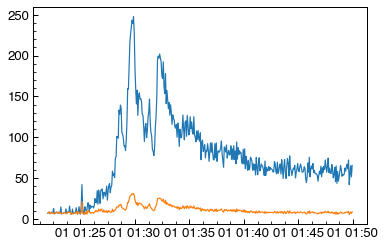

In [21]:
plt.plot(test_resample1)
plt.plot(test_resample2)

(18932.05972222222, 18932.064930555556)

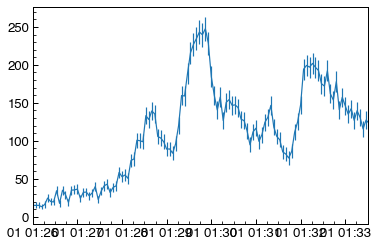

In [22]:
plt.errorbar(test_resample1.index, test_resample1.values, np.sqrt(error_resample).values)
plt.xlim("2021-11-01 01:26", "2021-11-01 01:33:30")

(18932.059027777777, 18932.064930555556)

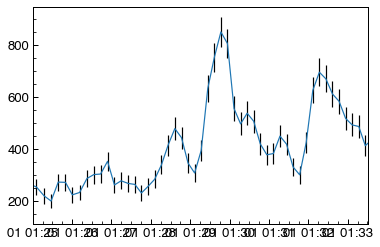

In [23]:
plt.errorbar(stix_data["times"].datetime, 
             np.sum(stix_data["counts"][:, :, :, 15:18], axis=(1, 2, 3)).value, 
             2*np.sqrt(np.sum(stix_data["counts"][:, :, :, 15:18], axis=(1, 2, 3)).value+np.sum(stix_data["counts_var"][:, :, :, 15:18], axis=(1, 2, 3)).value**2), 
             #drawstyle="steps-mid", 
             ecolor="k")
plt.xlim("2021-11-01 01:25", "2021-11-01 01:33:30")

<ErrorbarContainer object of 3 artists>

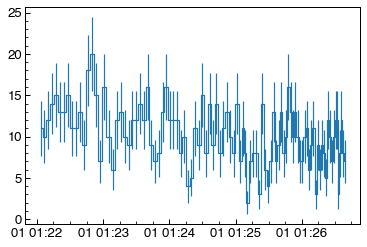

In [24]:
plt.errorbar(stix_data_spec["times"].datetime[0:100], 
             stix_data_spec["counts"][0:100, 15].value, 
             np.sqrt(stix_data_spec["counts"][0:100, 15].value + stix_data_spec["counts_var"][0:100, 15].value**2), drawstyle="steps-mid")           

In [25]:
stix_data_spec_sub = stix_data_spec.copy()
stix_data_spec_sub["count_rate"] = stix_data_spec_sub["count_rate"] - np.sum(stix_bg_data["count_rate"], axis=(1, 2))

In [26]:
inds_en_stix = np.where((stix_data["e_low"].value>=10)&(stix_data["e_low"].value<=50))[0]

In [27]:
def plot_struct(stix_data, spec=False):
    cmap=plt.cm.viridis.copy()
    cmap.set_bad(cmap(0))
    if not spec:
        stix_spec = np.mean(stix_data["count_rate"], axis=(1,2))
    else:
        stix_spec = stix_data["count_rate"]
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.pcolormesh(stix_data["times"].datetime, stix_data["e_low"].value[inds_en_stix], 
                  stix_spec[:, inds_en_stix].T/6, 
                  norm=colors.LogNorm(vmin=0.06, vmax=50), cmap=cmap)
    ax.set_yscale("log")
    ax.set_ylim(10, 100)
    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
    ax.set_xlabel("Time {:s} UT".format(stix_data["times"][0].strftime("%Y-%m-%d")))
    cbar = fig.colorbar(im)
    cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    

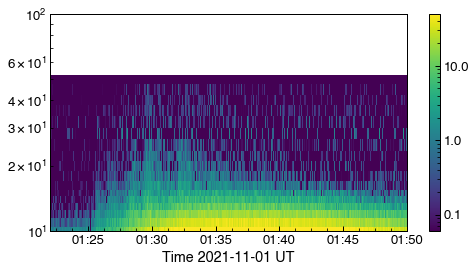

In [28]:
plot_struct(stix_data_spec_sub, spec=True)

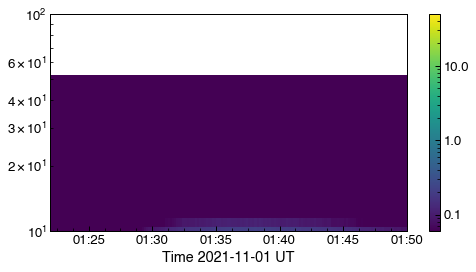

In [29]:
plot_struct(stix_data)

(10, 100)

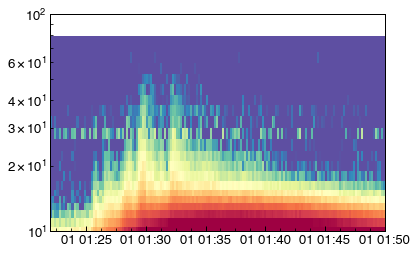

In [30]:
cmap = plt.cm.Spectral_r.copy()
cmap.set_bad(cmap(0))
stix_en_inds = np.where((stix_data_sub["e_low"].value>=10)&(stix_data_sub["e_high"].value<100))[0]
plt.pcolormesh(stix_data_sub["times"].datetime, stix_data_sub["e_low"].value[stix_en_inds], 
               stix_data_sub["spec"][:, stix_en_inds].T/6, 
               norm=colors.LogNorm(vmin=0.06, vmax=30), cmap=cmap)
plt.yscale("log")
plt.ylim(10, 100)



Text(0, 0.5, 'STIX Energy (keV)')

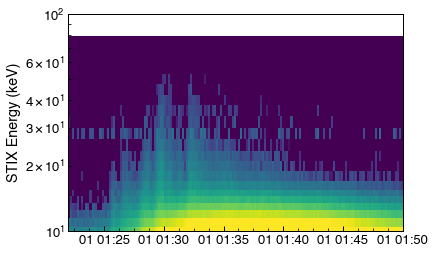

In [31]:
fig, ax = plt.subplots()
cmap_stix = plt.cm.viridis.copy()
cmap_stix.set_bad(cmap_stix(0))
stix_en_inds = np.where((stix_data_sub["e_low"].value>=10)&(stix_data_sub["e_high"].value<100))[0]
im_stix = ax.pcolormesh(stix_data_sub["times"].datetime, stix_data_sub["e_low"].value[stix_en_inds], 
               np.sum(stix_data_sub["count_rate"], axis=(1,2))[:, stix_en_inds].T/6, 
               norm=colors.PowerNorm(gamma=1./4, vmin=0.1, vmax=30), cmap=cmap_stix)
ax.set_yscale("log")
ax.set_ylim(10, 100)
ax.set_ylabel("STIX Energy (keV)")

## FERMI data

In [32]:
detectors = [1, 3, 4, 5]
detector = 5
fermi_file = "glg_cspec_n{:d}_211101_v00.pha".format(detector)


In [33]:
def read_gbm(fermi_file, tstart, tend):
    hdu_fermi = fits.open(fermi_file)

    data_file = fits.open(fermi_file)
    energies = data_file[1].data
    count_data = data_file[2].data


    met_ref_time = parse_time('2001-01-01 00:00')  # Mission elapsed time
    gbm_times = met_ref_time + count_data['time']*u.s
    gbm_times.precision = 9
    gbm_times = gbm_times.isot.astype('datetime64')

    gbm_counts = count_data["counts"]
    exptime = count_data["exposure"]
    quality = count_data["quality"] # 1 is bad

    truncated_inds = (gbm_times>=tstart)*(gbm_times<=tend)
    gbm_count_array = gbm_counts[truncated_inds, :]
    gbm_time_array = gbm_times[truncated_inds]
    gbm_exptime = exptime[truncated_inds]
    gbm_quality = quality[truncated_inds]

    dE_gbm = (energies['e_max'] - energies['e_min'])
    e_norm_gbm = dE_gbm.reshape(1, -1)
    t_norm_gbm = gbm_exptime.reshape(-1, 1)

    gbm_count_rate = gbm_count_array/e_norm_gbm/t_norm_gbm
    
    gbm_struct = {"counts": gbm_count_array, "time_array":gbm_time_array, "count_rate":gbm_count_rate, 
                  "e_min": energies["e_min"], "e_max": energies["e_max"], "quality":gbm_quality}
    return gbm_struct

In [34]:
gbm_struct = read_gbm(fermi_file, tstart, tend)

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_11647/3316630152.py:28: RuntimeWarning: invalid value encountered in divide
  gbm_count_rate = gbm_count_array/e_norm_gbm/t_norm_gbm


In [35]:
e_inds_gbm = (gbm_struct["e_min"]>=10)&(gbm_struct["e_min"]<=100)


fix bad data with the subsequent data value

In [36]:
bad_flags = np.where(gbm_struct["quality"]==1)[0]

In [37]:
gbm_struct["count_rate"][bad_flags, :] = gbm_struct["count_rate"][bad_flags+1, :]

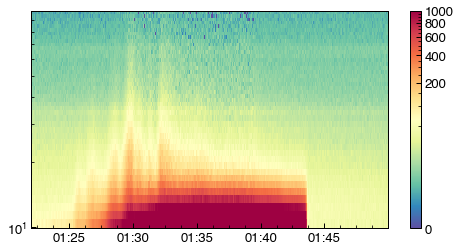

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
               gbm_struct["count_rate"][:, e_inds_gbm].T, 
               norm=colors.PowerNorm(gamma=1./4, vmax=1000, vmin=1),cmap="Spectral_r")

plt.yscale("log")
plt.colorbar()
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

In [39]:
det_area = np.pi*((12.7/2)*u.cm)**2

In [40]:
det_area

<Quantity 126.67686977 cm2>

In [41]:
sns.set_context("talk", font_scale=1., rc={"font.family" : "Helvetica"})

## Plot timeseries

In [61]:
    
def read_l1a_pandas(stix_file, ebands=[4, 10, 15, 20, 28]*u.keV, timeshift=0*u.s):
    file = stix_file
    file = Path(file)
    header = fits.getheader(file)
    control = QTable.read(file, hdu=1)
    data = QTable.read(file, hdu=2)
    data['time'] = Time(header['date_obs']) + data['time']
    energies = QTable.read(file, hdu=3)
    data["time"] = data["time"] + timeshift

    dE = (energies['e_high'] - energies['e_low'])
    dE[[0, -1]] = 1 * u.keV
    e_norm = dE
    t_norm = data["timedel"]

    e_norm = e_norm.reshape(1, 1, 1, -1)
    t_norm = t_norm.reshape(-1, 1, 1, 1)

    energies["e_high"][-1] = 151*u.keV

    counts = data["counts"]
    counts_var = data['counts_err']**2

    #ebands = [4, 10, 15, 20, 28]*u.keV
    summary_counts = []
    summary_counts_err = []
    column_labels = []
    for i in range(len(ebands)-1):

        ind_start = np.argmin(np.abs(energies["e_low"]-ebands[i]))
        ind_end = np.argmin(np.abs(energies["e_high"]-ebands[i+1]))

        e_l = energies["e_low"][ind_start].value
        e_h = energies["e_high"][ind_end].value
        band = "{:d}-{:d} keV".format(int(e_l), int(e_h))
        column_labels.append(band)

        energy_width = (energies["e_high"][ind_end] - energies["e_low"][ind_start]) 
        e_norm_new = energy_width.reshape(1, 1, 1, -1)

        count_sum = np.sum(counts[..., ind_start:ind_end], axis=(1, 2, 3), keepdims=True)

        count_sum_err = np.sum(counts_var[..., ind_start:ind_end], axis=(1, 2, 3), keepdims=True)

        # get in rate
        count_rate_err = np.sqrt(count_sum*u.ct + count_sum_err)/(t_norm*e_norm_new)
        count_rate = count_sum / (t_norm*e_norm_new)    


        summary_counts.append(count_rate.reshape(-1))
        summary_counts_err.append(count_rate_err.reshape(-1))

    summary_counts = np.array(summary_counts).T
    summary_counts_err = np.array(summary_counts_err).T
    
    #column_labels = ["4-10 keV", "10-15 keV", "15-20 keV", "20-28 keV"]
    stix_crate = pd.DataFrame(summary_counts, index=data["time"].datetime, columns=column_labels)
    stix_crate_err = pd.DataFrame(summary_counts_err, index=data["time"].datetime, columns=column_labels)
    return stix_crate, stix_crate_err

In [73]:
stix_ts, stix_err = read_l1a_pandas(stix_filel1, timeshift=82.529999*u.s, ebands=[4, 10, 15, 25, 50, 100]*u.keV)

In [85]:
gbm_ts = ts.TimeSeries(fermi_file)

/Users/laura.hayes/opt/miniconda3/envs/stix_directivity/lib/python3.10/site-packages/sunpy/timeseries/sources/fermi_gbm.py:224: RuntimeWarning: invalid value encountered in divide
  summary_counts.append(summed_counts/energy_width/count_data["exposure"])


In [86]:
gbm_flare = gbm_ts.truncate(tstart.datetime, tend.datetime).to_dataframe()
gbm_flare[gbm_flare==0]=np.nan

In [87]:
gbm_flare = gbm_flare.resample("1s").mean().interpolate()

In [88]:
gbm_flare

,4-15 keV,15-25 keV,25-50 keV,50-100 keV,100-300 keV,300-800 keV,800-2000 keV
2021-11-01 01:22:01,122.714443,29.792011,11.113117,3.384756,0.780670,0.103524,0.059109
2021-11-01 01:22:02,123.105916,29.779899,11.034650,3.327448,0.767917,0.106649,0.058039
2021-11-01 01:22:03,123.497390,29.767788,10.956183,3.270141,0.755165,0.109774,0.056968
2021-11-01 01:22:04,123.888864,29.755676,10.877717,3.212833,0.742412,0.112899,0.055898
2021-11-01 01:22:05,124.280337,29.743564,10.799250,3.155526,0.729659,0.116024,0.054827
...,...,...,...,...,...,...,...
2021-11-01 01:49:52,25.352802,22.796779,9.209675,3.400556,1.047715,0.148183,0.122208
2021-11-01 01:49:53,25.518699,23.004888,9.163195,3.412447,1.038626,0.148805,0.121089
2021-11-01 01:49:54,25.684596,23.212998,9.116715,3.424338,1.029537,0.149428,0.119971
2021-11-01 01:49:55,25.850493,23.421108,9.070234,3.436229,1.020448,0.150051,0.118852


In [89]:
%matplotlib inline

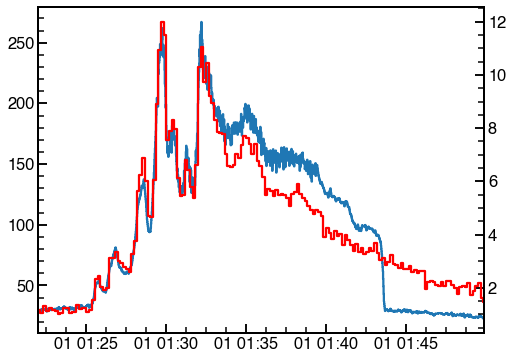

In [93]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(gbm_flare["15-25 keV"], drawstyle="steps-mid")
ax.set_xlim(gbm_flare.index[0], gbm_flare.index[-1])
ax2 = ax.twinx()
ax2.plot(stix_ts["15-25 keV"], color='r', drawstyle="steps-mid")

In [96]:
stix_data_spec["e_low"]

<Quantity [  0.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
            13.,  14.,  15.,  16.,  18.,  20.,  22.,  25.,  28.,  32.,
            36.,  40.,  45.,  50.,  56.,  63.,  70.,  76.,  84., 100.,
           120., 150.] keV>

In [97]:
stix_data_spec["e_high"]

<Quantity [  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
            14.,  15.,  16.,  18.,  20.,  22.,  25.,  28.,  32.,  36.,
            40.,  45.,  50.,  56.,  63.,  70.,  76.,  84., 100., 120.,
           150.,  inf] keV>

# Plot together!

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_34827/279147451.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


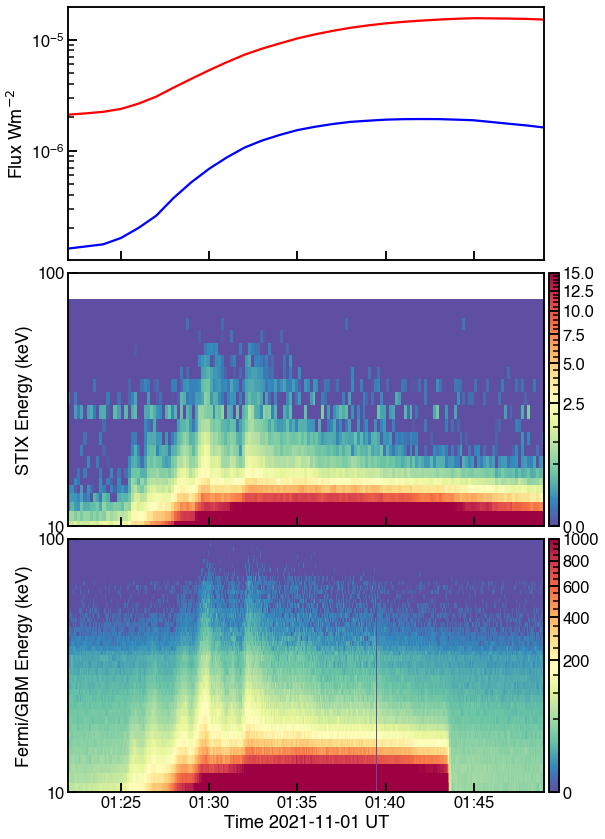

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8, 12))
# GOES plot
ax1.plot(gl, color='r', label="1-8$\mathrm{\AA}$")
ax1.plot(gs, color='b', label="0.5-4$\mathrm{\AA}$")
ax1.set_yscale("log")
ax1.set_ylabel("Flux Wm$^{-2}$")
ax1.set_xlim(gl.index[0], gl.index[-1])

# STIX plot
cmap_stix = plt.cm.Spectral_r.copy()
cmap_stix.set_bad(cmap_stix(0))
stix_en_inds = np.where((stix_data_sub["e_low"].value>=10)&(stix_data_sub["e_high"].value<100))[0]
im_stix = ax2.pcolormesh(stix_data_sub["times"].datetime, stix_data_sub["e_low"].value[stix_en_inds], 
               np.sum(stix_data_sub["count_rate"], axis=(1,2))[:, stix_en_inds].T/6, 
               norm=colors.PowerNorm(gamma=0.4, vmin=0.06, vmax=15), cmap=cmap_stix)
ax2.set_yscale("log")
ax2.set_ylim(10, 100)
ax2.set_ylabel("STIX Energy (keV)")


# GBM plot
ax3.sharey(ax2)
im_fermi = ax3.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
               gbm_struct["count_rate"][:, e_inds_gbm].T, 
               norm=colors.PowerNorm(gamma=0.4, vmin=5, vmax=1000), cmap=cmap_stix)
ax3.set_yscale("log")
ax3.set_ylabel("Fermi/GBM Energy (keV)")

ax1.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax2.set_yticks([10, 100])
ax2.minorticks_off()
ax3.set_yticks([10, 100])
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax3.yaxis.set_major_formatter(ticker.ScalarFormatter())


axins_fermi = inset_axes(ax3,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )

axins_stix = inset_axes(ax2,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )


cbar_fermi = fig.colorbar(im_fermi, cax=axins_fermi, orientation='vertical')
cbar_stix = fig.colorbar(im_stix, cax=axins_stix, orientation='vertical')

cbar_stix.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

cbar_fermi.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


ax3.set_xlabel("Time {:s} UT".format(gl.index[0].strftime("%Y-%m-%d")))
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)

plt.savefig("overview_nov_pnorm.png")

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_34827/2308256405.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


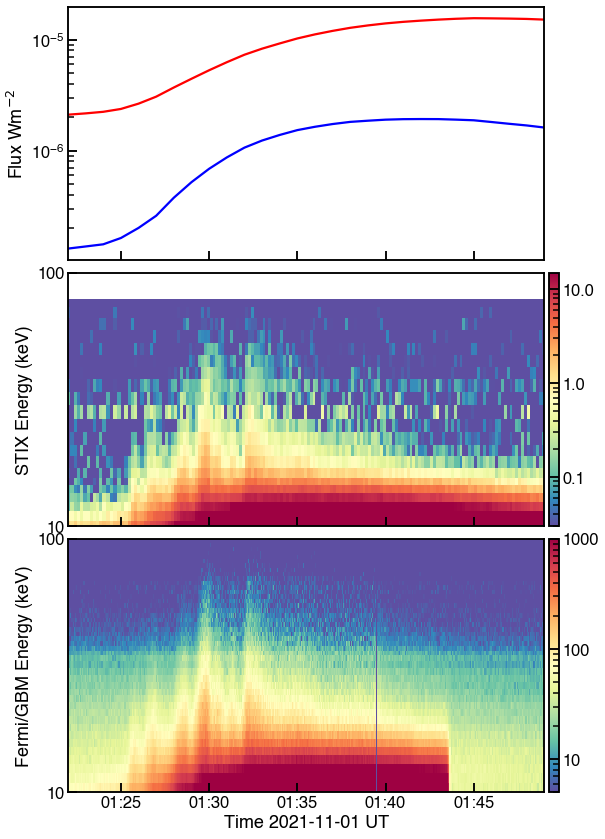

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8, 12))
# GOES plot
ax1.plot(gl, color='r', label="1-8$\mathrm{\AA}$")
ax1.plot(gs, color='b', label="0.5-4$\mathrm{\AA}$")
ax1.set_yscale("log")
ax1.set_ylabel("Flux Wm$^{-2}$")
ax1.set_xlim(gl.index[0], gl.index[-1])

# STIX plot
cmap_stix = plt.cm.Spectral_r.copy()
cmap_stix.set_bad(cmap_stix(0))
stix_en_inds = np.where((stix_data_sub["e_low"].value>=10)&(stix_data_sub["e_high"].value<100))[0]
im_stix = ax2.pcolormesh(stix_data_sub["times"].datetime, stix_data_sub["e_low"].value[stix_en_inds], 
               np.sum(stix_data_sub["count_rate"], axis=(1,2))[:, stix_en_inds].T/6, 
               norm=colors.LogNorm(vmin=0.03, vmax=15), cmap=cmap_stix)
ax2.set_yscale("log")
ax2.set_ylim(10, 100)
ax2.set_ylabel("STIX Energy (keV)")


# GBM plot
ax3.sharey(ax2)
im_fermi = ax3.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
               gbm_struct["count_rate"][:, e_inds_gbm].T, 
               norm=colors.LogNorm(vmin=5, vmax=1000), cmap=cmap_stix)
ax3.set_yscale("log")
ax3.set_ylabel("Fermi/GBM Energy (keV)")

ax1.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax2.set_yticks([10, 100])
ax2.minorticks_off()
ax3.set_yticks([10, 100])
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax3.yaxis.set_major_formatter(ticker.ScalarFormatter())


axins_fermi = inset_axes(ax3,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )

axins_stix = inset_axes(ax2,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )


cbar_fermi = fig.colorbar(im_fermi, cax=axins_fermi, orientation='vertical')
cbar_stix = fig.colorbar(im_stix, cax=axins_stix, orientation='vertical')

cbar_stix.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

cbar_fermi.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


ax3.set_xlabel("Time {:s} UT".format(gl.index[0].strftime("%Y-%m-%d")))
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)

plt.savefig("overview_nov_lnorm.png")

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_34827/678914402.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


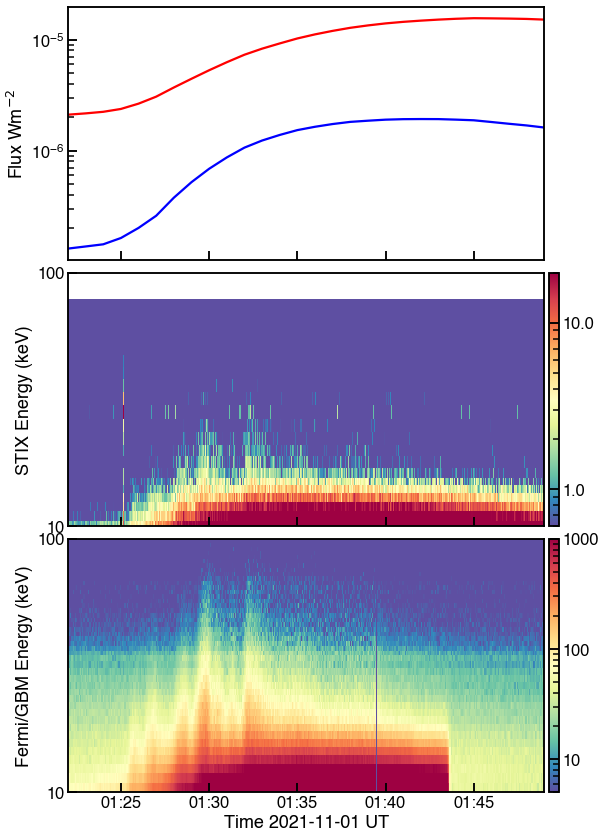

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8, 12))
# GOES plot
ax1.plot(gl, color='r', label="1-8$\mathrm{\AA}$")
ax1.plot(gs, color='b', label="0.5-4$\mathrm{\AA}$")
ax1.set_yscale("log")
ax1.set_ylabel("Flux Wm$^{-2}$")
ax1.set_xlim(gl.index[0], gl.index[-1])

# STIX plot
cmap_stix = plt.cm.Spectral_r.copy()
cmap_stix.set_bad(cmap_stix(0))
stix_en_inds = np.where((stix_data_spec_sub["e_low"].value>=10)&(stix_data_spec_sub["e_high"].value<100))[0]
im_stix = ax2.pcolormesh(stix_data_spec_sub["times"].datetime, stix_data_spec_sub["e_low"].value[stix_en_inds], 
               stix_data_spec_sub["count_rate"][:, stix_en_inds].T/6, 
               norm=colors.LogNorm(vmin=0.6, vmax=20), cmap=cmap_stix)
ax2.set_yscale("log")
ax2.set_ylim(10, 100)
ax2.set_ylabel("STIX Energy (keV)")


# GBM plot
ax3.sharey(ax2)
im_fermi = ax3.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
               gbm_struct["count_rate"][:, e_inds_gbm].T, 
               norm=colors.LogNorm(vmin=5, vmax=1000), cmap=cmap_stix)
ax3.set_yscale("log")
ax3.set_ylabel("Fermi/GBM Energy (keV)")

ax1.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax2.set_yticks([10, 100])
ax2.minorticks_off()
ax3.set_yticks([10, 100])
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax3.yaxis.set_major_formatter(ticker.ScalarFormatter())


axins_fermi = inset_axes(ax3,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )

axins_stix = inset_axes(ax2,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )


cbar_fermi = fig.colorbar(im_fermi, cax=axins_fermi, orientation='vertical')
cbar_stix = fig.colorbar(im_stix, cax=axins_stix, orientation='vertical')

cbar_stix.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

cbar_fermi.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


ax3.set_xlabel("Time {:s} UT".format(gl.index[0].strftime("%Y-%m-%d")))
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)


plt.savefig("overview_nov_spec.png")

## Try STIX spec data

## Plot the timeseries

In [600]:
ind_2028_gbm = (gbm_struct["e_min"]>=20)&(gbm_struct["e_max"]<=28)
test_2028 = pd.Series(np.sum(gbm_struct["count_rate"][:, ind_2028_gbm], axis=1), index=gbm_struct["time_array"])

for i in range(np.sum(ind_2028_gbm)):
    print(gbm_struct["e_min"][ind_2028_gbm][i], gbm_struct["e_max"][ind_2028_gbm][i])

20.70291 22.07131
22.07131 23.457895
23.457895 24.877317
24.877317 26.344217


In [601]:
ind_2028_stix = (stix_data["e_low"].value>=20)&(stix_data["e_high"].value<=28)
test_stix_2028 = pd.Series(np.sum(np.sum(stix_data["count_rate"], axis=(1, 2))[:, ind_2028_stix], axis=1), 
                           index=stix_data["times"].datetime)
for i in range(np.sum(ind_2028_stix)):
    print(stix_data["e_low"][ind_2028_stix][i], stix_data["e_high"][ind_2028_stix][i])

20.0 keV 22.0 keV
22.0 keV 25.0 keV
25.0 keV 28.0 keV


In [602]:
ind_2028_stix2 = (stix_data_spec["e_low"].value>=20)&(stix_data_spec["e_high"].value<=28)
test_stix_2028_spec = pd.Series(np.sum(stix_data_spec["count_rate"][:, ind_2028_stix2], axis=1), 
                           index=stix_data_spec["times"].datetime)
for i in range(np.sum(ind_2028_stix2)):
    print(stix_data_spec["e_low"][ind_2028_stix2][i], stix_data_spec["e_high"][ind_2028_stix2][i])

20.0 keV 22.0 keV
22.0 keV 25.0 keV
25.0 keV 28.0 keV


In [603]:
gbm_test = test_2028.resample("4s").mean().interpolate()
stix_test = test_stix_2028.resample("4s").mean().interpolate()
stix_test_spec = test_stix_2028_spec.resample("4s").mean().interpolate()

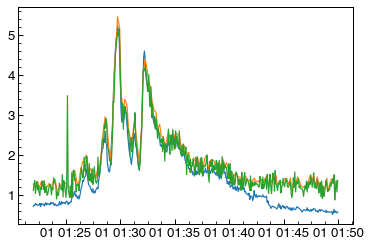

In [604]:
fig, ax = plt.subplots()
ax.plot((gbm_test)/127)
ax.plot(stix_test/6)
ax.plot(stix_test_spec/6)

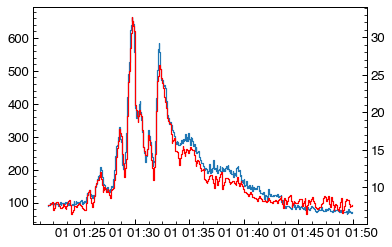

In [605]:
fig, ax = plt.subplots()
ax.plot(gbm_test, drawstyle="steps-mid")
ax2 = ax.twinx()
ax2.plot(stix_test , drawstyle="steps-mid", color='r')

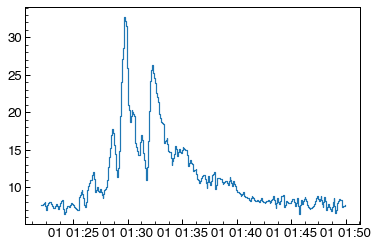

In [606]:
plt.plot(test_stix_2028.resample("4s").mean().interpolate(), drawstyle="steps-mid")

In [77]:
def read_and_plot_ospex_outputs():
    stix_file = "stx_spectrum_20211101_0040.fits"
    aa = fits.open(stix_file)
    count_rate = aa[1].data["RATE"]
    time = aa[1].data["TIME"]
    times = (Time(aa[1].header["MJDREF"] + aa[1].header["TIMEZERO"], format="mjd") + aa[1].data["TIME"]*u.s).datetime
    t_start = parse_time("2021-11-01 01:20")
    t_end = parse_time("2021-11-01 01:50")

    tindices = np.where((times>=t_start)&(times<=t_end))[0]
    c_rate_trun = count_rate[tindices, :]
    t_trun = times[tindices]
    e_low = aa[2].data["E_MIN"]
    e_high = aa[2].data["E_MAX"]

    e_indices = np.where((e_low>=10))[0]
    e_trun = e_low[e_indices]

    cmap = plt.cm.Spectral_r.copy()

    cmap.set_bad(cmap(0))
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.pcolormesh(t_trun, e_trun, c_rate_trun[:, e_indices].T, cmap=cmap, 
                   norm=colors.LogNorm(vmin=0.001, vmax=100))
    plt.yscale("log")
    plt.ylim(10, 100)
    plt.colorbar()

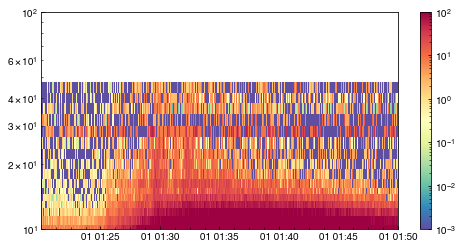

In [78]:
read_and_plot_ospex_outputs()

In [72]:
    stix_file = "stx_spectrum_20211101_0040.fits"
    aa = fits.open(stix_file)

In [28]:
for i in range(1, len(aa)):
    print(aa[i].data.dtype.names)

('RATE', 'STAT_ERR', 'CHANNEL', 'LIVETIME', 'SPEC_NUM', 'TIME', 'TIMEDEL')
('CHANNEL', 'E_MIN', 'E_MAX')
('SP_ATTEN_STATE$$TIME', 'SP_ATTEN_STATE$$STATE')
